Deux approches sont présentées.

Une approche classique : il s’agit de pre-processer des images avec des techniques spécifiques (e.g. whitening, equalisation, filtre linéaire/laplacien/gaussien, éventuellement modifier la taille des images), puis d’extraire des features (e.g. texture, corners, edges et SIFT detector). 

Il faut ensuite réduire les dimensions, soit par des approches classiques (e.g. PCA, k-means) soit avec une approche par histogrammes et dictionary learning (bag-of-words appliqué aux images), puis appliquer des algorithmes de classification standards.

Lors de l’analyse exploratoire, vous regarderez si les features extraites et utilisées en classification sont prometteuses en utilisant des méthodes de réduction de dimension pour visualiser le dataset en 2D. Cela vous permettra d’affiner votre intuition sur les différents traitements possibles, sans que cela ne se substitue à des mesures de performances rigoureuses.

Une approche s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels). Compte tenu de la taille et de la complexité du dataset, et de la puissance de calcul à votre disposition, il est très difficile d’obtenir de bonnes performances. 

Aussi, est-il recommandé d’utiliser le transfer learning, c’est-à-dire utiliser un réseau déjà entraîné, et le modifier pour répondre à votre problème. Une première chose obligatoire est de ré-entraîner les dernières couches pour prédire les classes qui vous intéressent seulement. 

Il est également possible d’adapter la structure (supprimer certaines couches par exemple) ou de ré-entraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

In [65]:
# Libraries nécessaires au projet

import os
import random
import warnings
import numpy as np
import pandas as pd
import scipy.ndimage
from scipy.cluster.vq import whiten
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from tqdm import tqdm
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import cv2

# Pour ne pas avoir les warnings lors de la compilation
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Variables globales

In [144]:
# Lieu où se trouvent des images
DOSSIER_SOURCE = '/home/toni/Bureau/p7/flow/'
IMG_DIR = '/home/toni/Bureau/p7/Images/'
SAVE_LIST = '/home/toni/Bureau/'

# Définitions des limites d'execution
NB_RACES = 3
NB_EXEMPLES = 50
NB_CLUSTER = int(NB_RACES * (NB_EXEMPLES/5))
AFFICHAGE_HISTOGRAMME = True
T_IMG = 90
BATCH_SIZE = 16
DATA_AUGMENTATION = False

# Setup a standard image size
STANDARD_SIZE = (300, 167)

# Fonctions utiles

<p style='color:#5F04B4'><b>Gestion de l'erreur quand une catégorie de chien n'est pas prédite. On rajoute la colonne vide manuellement</b></p>

In [47]:
def gestion_erreur(res, test_y, labels, classifieur):

    # Si ce n'est pas un kmeans, le traitement est différent (noms ou numéros)
    if classifieur == 'kmeans':
        for i in range(0, NB_RACES):
            if i not in res.columns:
                res[i] = 0

        for i in np.unique(labels):
            if i not in res.index:
                res.loc[i] = 0

    elif classifieur == 'cnn':
        for i in res.index:
            if i not in res.columns:
                res[i] = 0
    else:
        for i in np.unique(test_y):
            if i not in res.columns:
                res[i] = 0

        for i in res.columns:
            if i not in res.index:
                res.loc[i] = 0

    res = res.sort_index(axis=0, ascending=True)
    res = res.sort_index(axis=1, ascending=True)

    return res

<p style='color:#5F04B4'><b>Les deux filtres qui sont testés</b></p>

In [48]:
def fonction_median(img, param1):
    """
    Fonction de filtre
    """

    # Application du filtre
    img_modified = scipy.ndimage.median_filter(img, size=param1)

    return img_modified

def fonction_gauss(img, param1):
    """
    Fonction de filtre
    """

    # Application du filtre
    img_modified = scipy.ndimage.filters.gaussian_filter(img, sigma=param1)

    return img_modified

<p style='color:#5F04B4'><b>Transformation d'une image dans un array Numpy</b></p>

In [49]:
def img_to_matrix(filename, verbose=False):

    img = Image.open(filename)

    if verbose:
        print("changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE)))

    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = np.array(img)
    return img

<p style='color:#5F04B4'><b>Transformation d'un array Numpy en un array à 1 dimension</b></p>

In [50]:
def flatten_image(img):

    shape = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, shape)
    return img_wide[0]

<p style='color:#5F04B4'><b>Fonction qui récupére toute les images avec une sélection aléatoire. Rajout de filtres possibles</b></p>

In [51]:
def recup_images_filtres(liste_images, num_filtre):

    # Création des listes vides
    data = []

    for lien_image in liste_images:
        # Récupération de la matrice tranformée
        img = img_to_matrix(lien_image, False)

        if num_filtre == 1:
            # Filtre gaussien
            img = fonction_gauss(img, 5)
        elif num_filtre == 2:
            # Filtre médian
            img = fonction_median(img, 5)
        elif num_filtre == 3:
            img = whiten(img)

        # Mise à une dimension
        img = flatten_image(img)
        data.append(img)

        del img

    return data

<p style='color:#5F04B4'><b>Detection et extraction des features d'une image</b></p>

In [52]:
def features(img, extractor):

    img = cv2.imread(img)
    img = cv2.resize(img, STANDARD_SIZE)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, des = extractor.detectAndCompute(img, None)

    return keypoints, des

<p style='color:#5F04B4'><b>Fonction qui va calculer les pourcentages de bons pronostics.</b></p>


In [53]:
def calcul_resultats(res, test_y, classifieur):

    print("\nResultats pour", classifieur)

    # Transformation en tableau exploitable
    res1 = res.values

    data_resultats = pd.DataFrame(index=res.index, columns=['bons',
                                                            'prono',
                                                            'total',
                                                            'pc_prono',
                                                            'pc_total'])

    # Affichage des résultats
    print("Resultat :", round(100*res1.diagonal().sum()/len(test_y), 2), "%")
    print("No d'erreurs =", len(test_y) - res1.diagonal().sum(), "/", len(test_y))

    for i in range(0, len(res)):
        diagonale = res1.diagonal()[i]
        data_resultats.loc[res.index[i], 'bons'] = diagonale
        data_resultats.loc[res.index[i], 'prono'] = res.sum()[i]
        data_resultats.loc[res.index[i], 'total'] = res.sum('columns')[i]
        data_resultats.loc[res.index[i], 'pc_prono'] = round(100*diagonale/res.sum()[i], 2)
        data_resultats.loc[res.index[i], 'pc_total'] = round(100*diagonale/res.sum('columns')[i], 2)

    data_resultats = data_resultats.fillna(0)

    print(data_resultats)

<p style='color:#5F04B4'><b>Fonction qui extrait les features et permets de les clusterizer.</b></p>

In [54]:
def fonction_orb(liste_images):

    # Création des listes vides
    pool_descriptors = []

    #
    extractor = cv2.ORB_create()

    for lien_image in liste_images:
        # Récupération de la matrice tranformée
        keypoints, descriptors = features(lien_image, extractor)

        # Rajout à la liste
        pool_descriptors.append(descriptors)

    # Mise au bon format
    pool_descriptors = np.asarray(pool_descriptors)
    pool_descriptors = np.concatenate(pool_descriptors, axis=0)

    # Clusturisation des descriptors
    print("Training MiniBatchKMeans")
    kmeans = MiniBatchKMeans(n_clusters=NB_CLUSTER).fit(pool_descriptors)
    print("End training MiniBatchKMeans")

    return kmeans

<p style='color:#5F04B4'><b>Création de la liste aléatoire des chiens pour les races selectionnés.</b></p>

In [75]:
def etablir_liste_chiens():

    # Listes
    liste_dossier = []
    liste_images = []
    liste_images_cnn = []
    labels = []

    # Valeur initiale d'un compteur
    cpt_race = 0

    # Création de la liste aléatoire des races
    liste_chiens = os.listdir(IMG_DIR)
    for i in range(0, NB_RACES):
        nb_alea = random.randrange(0, len(liste_chiens))
        liste_dossier.append(liste_chiens[nb_alea])
        del liste_chiens[nb_alea]

    # Création de la liste aléatoire des chiens pour les races selectionnés
    for dirs in liste_dossier:
        # Valeur initiale d'un compteur
        cpt_exemple = 0
        if cpt_race < NB_RACES+1:
            cpt_race = cpt_race+1
            for filename in os.listdir(IMG_DIR + dirs):
                # On ne garde que NB_EXEMPLES exemplaires de chaque race
                if cpt_exemple < NB_EXEMPLES:
                    cpt_exemple = cpt_exemple+1

                    # Chemin complet de l'image
                    liste_images.append(IMG_DIR + dirs + '/' + filename)
                    liste_images_cnn.append(filename)

                    # Rajout du label
                    labels.append(dirs[dirs.find('-')+1:].lower())

    # Transformation de dataframe et exportation en csv
    liste_images_cnn = pd.DataFrame(liste_images_cnn, columns=['liste'])
    liste_images_cnn['labels'] = labels
    liste_images_cnn.to_csv(SAVE_LIST + 'liste.csv')
    
    return liste_images, labels

<p style='color:#5F04B4'><b>Création des centroids par la création des histogrammes des keypoints/features du kmeans.</b></p>

In [56]:
def calculate_centroids_histogram(liste_images, labels, model):

    # Création des listes vides
    feature_vectors = []
    class_vectors = []
    compteur = 0

    # Extracteur de features
    extractor = cv2.ORB_create() #cv2.xfeatures2d.SIFT_create()

    for lien_image in liste_images:
        # Récupération de la matrice tranformée
        keypoints, descriptors = features(lien_image, extractor)

        # classification of all descriptors in the model
        predict_kmeans = model.predict(descriptors)

        # calculates the histogram
        hist, bin_edges = np.histogram(predict_kmeans, bins=NB_CLUSTER)

        # Affichage des histogrammes
        if AFFICHAGE_HISTOGRAMME and compteur < 6:
            compteur = compteur + 1
            plt.hist(hist, bins=len(bin_edges), align='mid')
            plt.xlabel('bins')
            plt.ylabel('valeurs')
            plt.title('Histogramme')
            plt.show()

        # histogram is the feature vector
        feature_vectors.append(hist)

    # Mise sous la bonne forme
    feature_vectors = np.asarray(feature_vectors)
    class_vectors = np.asarray(labels)

    # return vectors and classes we want to classify
    return class_vectors, feature_vectors

<p style='color:#5F04B4'><b>Fonction avec utilise la technique bag of visual words.</b></p>

In [57]:
def fonction_bovw(liste_images, labels):

    print("\nFiltre ORB")

    # Séparation des datasets testing/training
    train_x, test_x, train_y, test_y = train_test_split(liste_images,
                                                        labels,
                                                        test_size=0.25)

    # Entrainement du modèle sur le dataset de training
    trained_model = fonction_orb(train_x)

    # Extraction des histogrammes
    [train_class, train_featvec] = calculate_centroids_histogram(train_x,
                                                                 train_y,
                                                                 trained_model)
    [test_class, test_featvec] = calculate_centroids_histogram(test_x,
                                                               test_y,
                                                               trained_model)

    # Utilisation des vecteurs de training pour entrainer le classifieur
    clf = svm.SVC()
    clf.fit(train_featvec, train_class)
    predict = clf.predict(test_featvec)

    # Calcul des résultats
    res = pd.crosstab(np.asarray(test_class),
                      predict,
                      rownames=["Actual"],
                      colnames=["Predicted"])

    # Gestion d'une erreur
    if len(res.columns) != NB_RACES:
        res = gestion_erreur(res, test_y, labels, 'svm')
    calcul_resultats(res, test_y, 'svm')

    # Test avec KNN()
    knn = KNeighborsClassifier(n_neighbors=50)
    knn.fit(train_featvec, train_class)
    predict = knn.predict(test_featvec)

    # Calcul des résultats
    res = pd.crosstab(np.asarray(test_class),
                      predict,
                      rownames=["Actual"],
                      colnames=["Predicted"])

    # Gestion d'une erreur
    if len(res.columns) != NB_RACES:
        res = gestion_erreur(res, test_y, labels, 'knn')
    calcul_resultats(res, test_y, 'knn')

<p style='color:#5F04B4'><b>Fonction avec filtres traditionnels.</b></p>

In [58]:
def fonction_filtres(liste_images, labels):

    for num_filtre in range(0, 4):
        if num_filtre == 0:
            nom_filtre = "Aucun"
        elif num_filtre == 1:
            nom_filtre = "Gaussien"
        elif num_filtre == 2:
            nom_filtre = "Median"
        elif num_filtre == 3:
            nom_filtre = "Whitening"

        print("\nFiltre", nom_filtre)
        data = recup_images_filtres(liste_images, num_filtre)

        ## Réduction de dimension
        # PCA
        pca = RandomizedPCA(n_components=2)
        data = pca.fit_transform(data)
        # Explication de la variance
        #print(pca.explained_variance_ratio_)

        # t-SNE
        #data = TSNE(n_components=2).fit_transform(data, labels)

        # Affichage en 2D après une décomposition
        affichage_decomposition(data, labels)

        # Séparation des datasets testing/training
        train_x, test_x, train_y, test_y = train_test_split(data,
                                                            labels,
                                                            test_size=0.25)

        # Transformation en array
        test_y = np.array(test_y)
        train_y = np.array(train_y)

        ## Création de la méthode de classification
        # Test avec KNN
        knn = KNeighborsClassifier(n_neighbors=10)
        knn.fit(train_x, train_y)
        res = pd.crosstab(test_y,
                          knn.predict(test_x),
                          rownames=["Actual"],
                          colnames=["Predicted"])

        # Gestion d'une erreur
        if len(res.columns) != NB_RACES:
            res = gestion_erreur(res, test_y, '0', 'knn')
        calcul_resultats(res, test_y, 'knn')

        # Test avec Kmeans
        kmeans = KMeans(n_clusters=NB_RACES).fit(train_x, train_y)
        res = pd.crosstab(test_y,
                          kmeans.predict(test_x),
                          rownames=["Actual"],
                          colnames=["Predicted"])

        # Gestion d'une erreur
        if len(res.columns) != NB_RACES:
            res = gestion_erreur(res, test_y, labels, 'kmeans')
        calcul_resultats(res, test_y, 'kmeans')

<p style='color:#5F04B4'><b>Affichage en 2D de la décomposition.</b></p>

In [59]:
def affichage_decomposition(data, labels):

    principaldf = pd.DataFrame(data=data,
                             columns=['principal component 1',
                                      'principal component 2'])

    finaldf = pd.concat([principaldf, pd.DataFrame(labels)], axis=1)

    data_labels = pd.DataFrame(labels)
    targets = []

    # Création de la liste des labels
    for i in data_labels[0].unique():
        targets.append(i)

    fig = plt.figure(figsize=(8, 8))
    axe = fig.add_subplot(1, 1, 1)
    axe.set_xlabel('Principal Component 1', fontsize=15)
    axe.set_ylabel('Principal Component 2', fontsize=15)
    axe.set_title('PCA components', fontsize=20)

    # Création de la liste des couleurs
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(targets)))

    # Affichage par catégorie
    for target, color in zip(targets, colors):
        indices_to_keep = finaldf[0] == target
        axe.scatter(finaldf.loc[indices_to_keep, 'principal component 1'],
                    finaldf.loc[indices_to_keep, 'principal component 2'],
                    c=color,
                    s=50)

    axe.legend(targets)
    axe.grid()
    plt.show()

# Fonctions utiles pour le cnn

<p style='color:#5F04B4'><b>Fonction pour la data augmentation.</b></p>

In [60]:
def cnn_data_augmentation(model, liste_train, liste_test):

    # DA pour le training
    train_datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                 width_shift_range=0.2,
                                                                 height_shift_range=0.2,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.2,
                                                                 horizontal_flip=True)

    train_generator = train_datagen.flow_from_dataframe(dataframe=liste_train,
                                                        directory=DOSSIER_SOURCE,
                                                        x_col='liste',
                                                        y_col='labels',
                                                        has_ext=True,
                                                        target_size=(T_IMG, T_IMG),
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

    # DA pour la validation
    valid_datagen = keras.preprocessing.image.ImageDataGenerator()

    valid_generator = valid_datagen.flow_from_dataframe(dataframe=liste_test,
                                                        directory=DOSSIER_SOURCE,
                                                        x_col='liste',
                                                        y_col='labels',
                                                        has_ext=True,
                                                        target_size=(T_IMG, T_IMG),
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical')

    hist = model.fit_generator(train_generator,
                               steps_per_epoch=2000 // BATCH_SIZE,
                               epochs=25,
                               validation_data=valid_generator,
                               validation_steps=200 // BATCH_SIZE)

    return hist

<p style='color:#5F04B4'><b>Fonction de transfert learning.</b></p>

In [142]:
def cnn_appel_vgg(x_train, y_train, x_valid, y_valid,liste_train, liste_test):

    # On crée un modèle déjà pré entrainé
    base_model = VGG19(weights=None, include_top=False, input_shape=(T_IMG, T_IMG, 3))

    # On rajoute les deux dernières couches qui nous intéressent
    x_model = base_model.output
    x_model = Flatten()(x_model)
    x_model = Dense(NB_RACES, activation='softmax')(x_model)

    # On crée notre modèle à partir de celui existant, et des deux couches en plus
    model = Model(inputs=base_model.input, outputs=x_model)

    # On choisi d'entrainer que nos couches rajoutées
    for layer in base_model.layers:
        layer.trainable = False

    # Compilatioon du modèle
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # On se donne des tours sans évolution pour stopper le fit
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc',
                                                    patience=5,
                                                    verbose=1)]

    # Visualisation de toutes les couches du modèle
    model.summary()

    if DATA_AUGMENTATION is True:
        res = cnn_data_augmentation(model, liste_train, liste_test)
    else:
        # Entrainement
        res = model.fit(x_train,
                        y_train,
                        epochs=5,
                        validation_data=(x_valid, y_valid),
                        verbose=1)

    # Tracé de courbes pour visualiser les résultats
    cnn_courbes(res)

    return model

<p style='color:#5F04B4'><b>Tracé des courbes d'accuracy et de log loss.</b></p>

In [62]:
def cnn_courbes(resultat):

    # Loss Curves
    plt.figure(figsize=[8, 6])
    plt.plot(resultat.history['loss'], 'r', linewidth=3.0)
    plt.plot(resultat.history['val_loss'], 'b', linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)

    # Accuracy Curves
    plt.figure(figsize=[8, 6])
    plt.plot(resultat.history['acc'], 'r', linewidth=3.0)
    plt.plot(resultat.history['val_acc'], 'b', linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)

<p style='color:#5F04B4'><b>Fonction de récupération des images.</b></p>

In [77]:
def cnn_recup_images():

    # Listes vides
    x_train = []
    y_train = []
    x_test = []

    # Etablissement du dataset de manière aléatoire
    etablir_liste_chiens()

    # Récupération de la liste des images
    liste_images = pd.read_csv(SAVE_LIST + 'liste.csv')
    del liste_images['Unnamed: 0']
    
    # Séparation des datasets testing/training
    liste_train, liste_test = train_test_split(liste_images,
                                               test_size=0.2)

    liste_train = liste_train.reset_index(drop="True")
    liste_test = liste_test.reset_index(drop="True")

    # Préparation du one-hot encoding
    targets_series = pd.Series(liste_train['labels'])
    one_hot = pd.get_dummies(targets_series, sparse=True)
    one_hot_labels = np.asarray(one_hot)
    
    # Récupération des images et des labels de training
    i = 0
    for file, dump in tqdm(liste_train.values):
        # Lecture de l'image
        img = cv2.imread(DOSSIER_SOURCE + file)

        # Rajout des données dans la liste
        x_train.append(cv2.resize(img, (T_IMG, T_IMG)))

        # Race du chien
        y_train.append(one_hot_labels[i])
        i = i + 1

    # Récupération des images de testing
    for file in tqdm(liste_test['liste'].values):
        # Lecture de l'image
        img = cv2.imread(DOSSIER_SOURCE + file)

        # Rajout des données dans la liste
        x_test.append(cv2.resize(img, (T_IMG, T_IMG)))

    return liste_train, liste_test, x_train, y_train, x_test

# Fonction principale

In [42]:
# Etablir la liste des chiens
liste_images, labels = etablir_liste_chiens()


Filtre Aucun


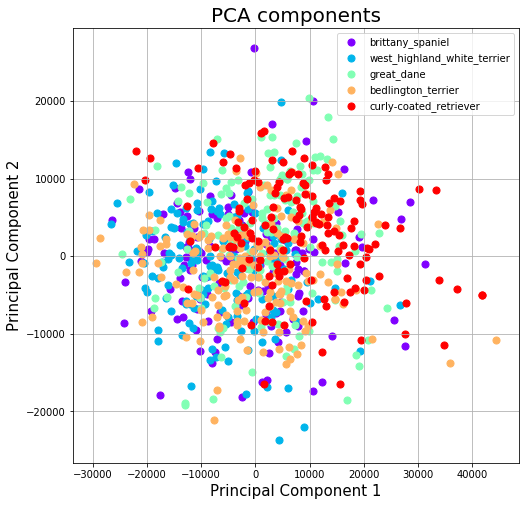


Resultats pour knn
Resultat : 26.6 %
No d'erreurs = 149 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier             18     73     45     24.66     40.00
brittany_spaniel                5     31     37     16.13     13.51
curly-coated_retriever         13     38     43     34.21     30.23
great_dane                      7     27     40     25.93     17.50
west_highland_white_terrier    11     34     38     32.35     28.95

Resultats pour kmeans
Resultat : 13.79 %
No d'erreurs = 175 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier              8     40     45     20.00     17.78
brittany_spaniel               13     51     37     25.49     35.14
curly-coated_retriever          0     37     43      0.00      0.00
great_dane                      4     20     40     20

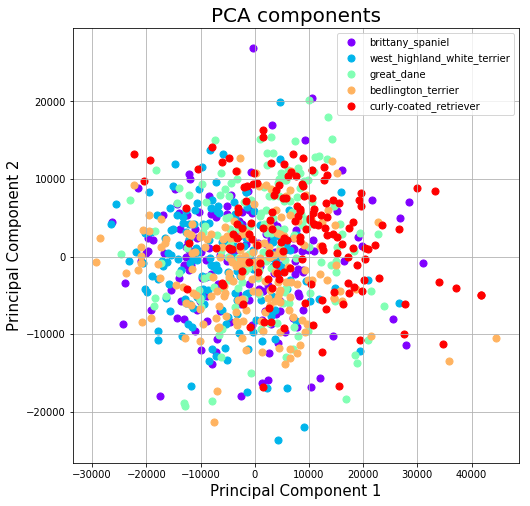


Resultats pour knn
Resultat : 28.57 %
No d'erreurs = 145 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier             24     67     54     35.82     44.44
brittany_spaniel                5     32     34     15.62     14.71
curly-coated_retriever         13     39     39     33.33     33.33
great_dane                      6     25     36     24.00     16.67
west_highland_white_terrier    10     40     40     25.00     25.00

Resultats pour kmeans
Resultat : 17.24 %
No d'erreurs = 168 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier              3     24     54     12.50      5.56
brittany_spaniel                9     48     34     18.75     26.47
curly-coated_retriever         12     47     39     25.53     30.77
great_dane                      3     45     36      

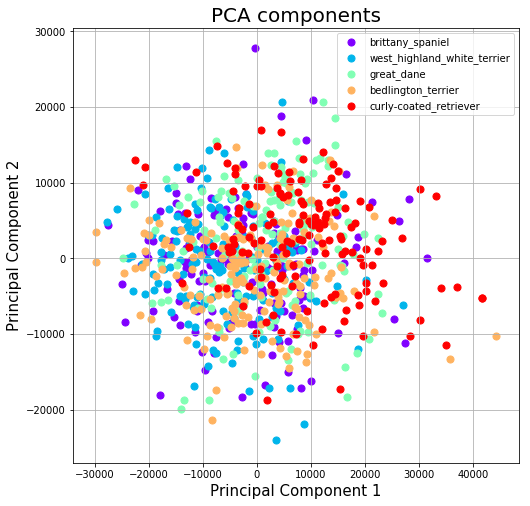


Resultats pour knn
Resultat : 23.15 %
No d'erreurs = 156 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier             12     69     37     17.39     32.43
brittany_spaniel                4     41     35      9.76     11.43
curly-coated_retriever         13     28     46     46.43     28.26
great_dane                      8     22     48     36.36     16.67
west_highland_white_terrier    10     43     37     23.26     27.03

Resultats pour kmeans
Resultat : 26.11 %
No d'erreurs = 150 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier              9     42     37     21.43     24.32
brittany_spaniel               11     48     35     22.92     31.43
curly-coated_retriever         17     39     46     43.59     36.96
great_dane                      7     21     48     3

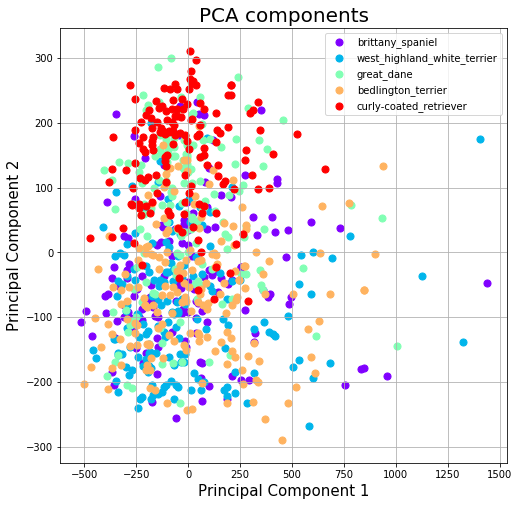


Resultats pour knn
Resultat : 31.03 %
No d'erreurs = 140 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier             17     69     40     24.64     42.50
brittany_spaniel                7     33     37     21.21     18.92
curly-coated_retriever         23     48     35     47.92     65.71
great_dane                      4     20     43     20.00      9.30
west_highland_white_terrier    12     33     48     36.36     25.00

Resultats pour kmeans
Resultat : 15.76 %
No d'erreurs = 171 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier             11     41     40     26.83     27.50
brittany_spaniel               13     58     37     22.41     35.14
curly-coated_retriever          4     45     35      8.89     11.43
great_dane                      0      9     43      

In [43]:
fonction_filtres(liste_images, labels)



Filtre ORB
Training MiniBatchKMeans
End training MiniBatchKMeans


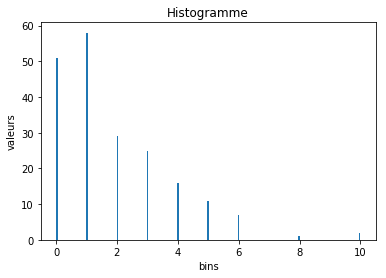

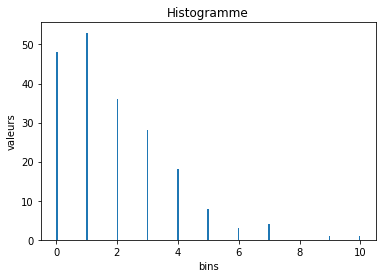

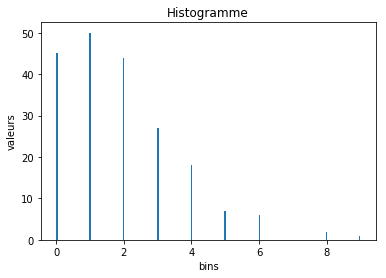

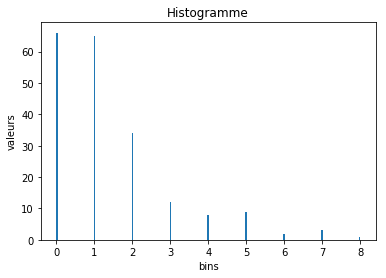

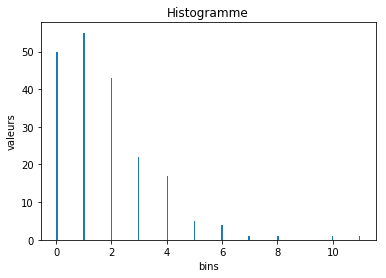

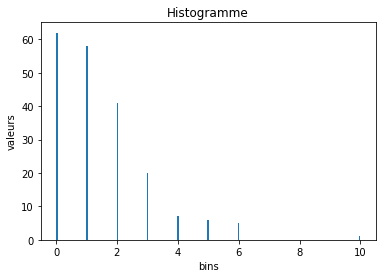

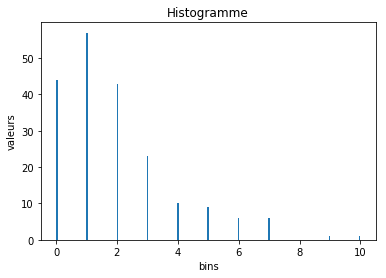

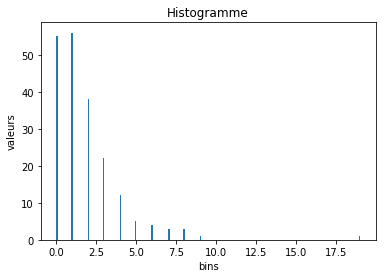

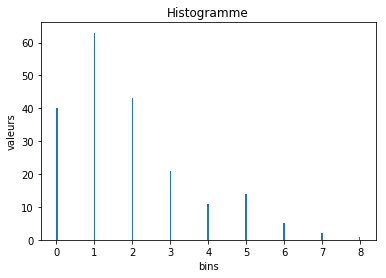

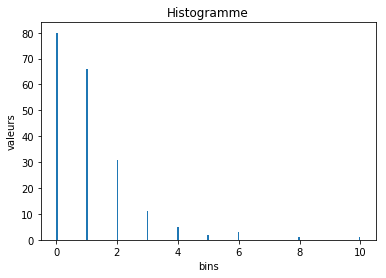

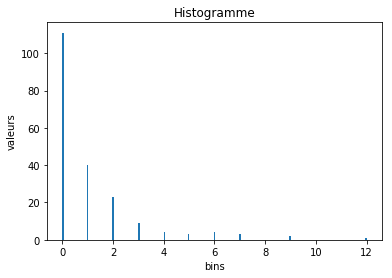

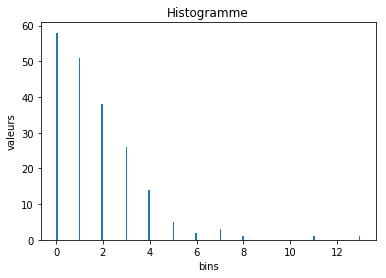


Resultats pour svm
Resultat : 30.54 %
No d'erreurs = 141 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier             37    113     48     32.74     77.08
brittany_spaniel                0      0     35      0.00      0.00
curly-coated_retriever          3      3     41    100.00      7.32
great_dane                      0      1     41      0.00      0.00
west_highland_white_terrier    22     86     38     25.58     57.89

Resultats pour knn
Resultat : 32.02 %
No d'erreurs = 138 / 203
                             bons  prono  total  pc_prono  pc_total
Actual                                                             
bedlington_terrier             30     91     48     32.97     62.50
brittany_spaniel                1      8     35     12.50      2.86
curly-coated_retriever         13     32     41     40.62     31.71
great_dane                     19     68     41     27.9

In [44]:
fonction_bovw(liste_images, labels)

# Fonction principale pour le cnn

In [140]:
# Appel de la fonction pour récupérer les images
liste_train, liste_test, x_train, y_train, x_test = cnn_recup_images()

# Reformatage des listes pour le format de VGG19
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test = np.array(x_test, np.float32) / 255.

# Vérification des données
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test.shape)

# Séparation des datasets training/validation
x_train, x_valid, y_train, y_valid = train_test_split(x_train_raw,
                                                      y_train_raw,
                                                      test_size=0.3,
                                                      random_state=1)

100%|██████████| 30/30 [00:00<00:00, 344.50it/s]

(120, 90, 90, 3)
(120, 3)
(30, 90, 90, 3)


In [145]:
# Appel de la fonction de transfer learning
model = cnn_appel_vgg(x_train,
                      y_train,
                      x_valid,
                      y_valid,
                      liste_train,
                      liste_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 90, 90, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 90, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 90, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 22, 128)       0         
__________

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,128,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block3_conv1_9/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=1246701, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block3_conv1_9/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'block3_conv1_9/random_uniform/RandomUniform', defined at:
  File "/home/toni/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/toni/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/toni/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/toni/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/toni/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/toni/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/toni/anaconda3/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/toni/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/toni/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/toni/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-145-3900350ef4fe>", line 7, in <module>
    liste_test)
  File "<ipython-input-142-5c6181bc434c>", line 4, in cnn_appel_vgg
    base_model = VGG19(weights=None, include_top=False, input_shape=(T_IMG, T_IMG, 3))
  File "/home/toni/anaconda3/lib/python3.6/site-packages/keras/applications/__init__.py", line 28, in wrapper
    return base_fun(*args, **kwargs)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/keras/applications/vgg19.py", line 11, in VGG19
    return vgg19.VGG19(*args, **kwargs)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/keras_applications/vgg19.py", line 134, in VGG19
    name='block3_conv1')(x)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/home/toni/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 141, in build
    constraint=self.kernel_constraint)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer.py", line 249, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/toni/anaconda3/lib/python3.6/site-packages/keras/initializers.py", line 218, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 4139, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py", line 449, in _random_uniform
    name=name)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/home/toni/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,128,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block3_conv1_9/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=1246701, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block3_conv1_9/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
# Calcul des résultats
predictions = model.predict(x_valid)
predictions = np.argmax(predictions, axis=1)
truth = np.argmax(y_valid, axis=1)

res = pd.crosstab(np.asarray(truth),
                  predictions,
                  rownames=["Actual"],
                  colnames=["Predicted"])

# Gestion d'une erreur
if len(res.columns) != NB_RACES:
    res = gestion_erreur(res, predictions, liste_train['labels'], 'cnn')
cnn_calcul_resultats(res, np.asarray(predictions), 'cnn')

errors = np.where(predictions != truth)[0]
print("No of errors =", len(errors), "/", len(predictions))